In [1]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import urllib.request
import matplotlib as mpl
import numpy as np
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf
tf.get_logger().setLevel('INFO')
gpus = tf.config.experimental.list_physical_devices(device_type='GPU')
tf.config.experimental.set_visible_devices(devices=gpus[1], device_type='GPU')
tf.config.experimental.set_memory_growth(device=gpus[1], enable=True)
import urllib
from dataclasses import dataclass
# import tensorflowjs as tfjs
# import tensorflow_decision_forests as tfdf
import json
from tqdm import tqdm
import seaborn as sns
import sys
np.random.seed(0)
urllib.request.urlretrieve('https://github.com/google/fonts/raw/main/ofl/ibmplexmono/IBMPlexMono-Regular.ttf', 'IBMPlexMono-Regular.ttf')
fe = font_manager.FontEntry(
    fname='IBMPlexMono-Regular.ttf',
    name='plexmono')
font_manager.fontManager.ttflist.append(fe)
plt.rcParams.update({'axes.facecolor':'#f5f4e9', 
            'grid.color' : '#AAAAAA', 
            'axes.edgecolor':'#333333', 
            'figure.facecolor':'#FFFFFF', 
            'axes.grid': False,
            'axes.prop_cycle':   plt.cycler('color', plt.cm.Dark2.colors),
            'font.family': fe.name,
            'figure.figsize': (3.5,3.5 / 1.2),
            'ytick.left': True,
            'xtick.bottom': True   
           })

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  2


In [10]:
urllib.request.urlretrieve(
    "https://github.com/ur-whitelab/peptide-ai/raw/master/scripts/active_learning_data/shp2-sequence-vectors.npy",
    "positive.npy",
)
urllib.request.urlretrieve(
    "https://github.com/ur-whitelab/peptide-ai/raw/master/scripts/active_learning_data/shp2-fake-sequence-vectors.npy",
    "negative.npy",
)

pos_ohe_data = np.load("positive.npy",  allow_pickle=True)
neg_ohe_data = np.load("negative.npy",  allow_pickle=True)

def ohe_to_seq(ohe_pep):
    alphabet = ['A','R','N','D','C','Q','E','G','H','I', 'L','K','M','F','P','S','T','W','Y','V']
    seq = ''
    # expect a 2D numpy array (pep_length x 20), give the string it represents
    for letter in ohe_pep[:int(np.sum(ohe_pep))]:
        idx = np.argmax(letter)
        if letter[idx] == 0:
            break
        seq += alphabet[idx]
    return(seq)

def encoder(seq, max_length=190):
    alphabet = ['A','R','N','D','C','Q','E','G','H','I', 'L','K','M','F','P','S','T','W','Y','V']
    vec = np.zeros(max_length)
    for i,l in enumerate(seq):
        vec[i] = alphabet.index(l) + 1
    return vec
pos_seqs = [ohe_to_seq(d) for d in pos_ohe_data]
pos_data = np.array([encoder(s) for s in pos_seqs])
neg_seqs = [ohe_to_seq(d) for d in neg_ohe_data]
neg_data = np.array([encoder(s) for s in neg_seqs])

labels = np.concatenate(
    (
        np.ones((pos_data.shape[0], 1), dtype=pos_data.dtype),
        np.zeros((neg_data.shape[0], 1), dtype=pos_data.dtype),
    ),
    axis=0,
)

features = np.concatenate((pos_data, neg_data), axis=0)
pos_data_lengths = np.count_nonzero(pos_data, axis=1)
neg_data_lengths = np.count_nonzero(neg_data, axis=1)

In [11]:
def decoder(seq_vector):
  alphabet = ['A','R','N','D','C','Q','E','G','H','I', 'L','K','M','F','P','S','T','W','Y','V']
  seq = []
  for i, index in enumerate(seq_vector.astype('int')):
    if index == 0:
      break
    seq.append(alphabet[index-1])
  seq = ''.join(seq)
  return seq

In [12]:
def counts_aa(vec):
    counts =  tf.histogram_fixed_width(vec, [0, 20], nbins=21)[1:]
    return counts /tf.reduce_sum(counts)


In [13]:
print('Positive data', pos_data.shape[0], pos_data.shape[0]/(pos_data.shape[0]+ neg_data.shape[0])*100)
print('Negative data', neg_data.shape[0], neg_data.shape[0]/(pos_data.shape[0]+ neg_data.shape[0])*100)

Positive data 150 50.0
Negative data 150 50.0


In [14]:
@dataclass
class Config:
    vocab_size: int
    example_number: int
    batch_size: int
    buffer_size: int
    rnn_units: int
    hidden_dim: int
    embedding_dim: int
    reg_strength: float
    lr: float
    drop_rate: float
        
config = Config(vocab_size=21, # include gap
                example_number=len(labels), 
                batch_size=16, 
                buffer_size=10000,
                rnn_units=64,
                hidden_dim=64,
                embedding_dim=32,
                reg_strength=0,
                lr=1e-3,
                drop_rate=0.1
               )

In [15]:
def counts_aa(vec):
    counts =  tf.histogram_fixed_width(vec, [0, 20], nbins=21)[1:]
    return counts /tf.reduce_sum(counts)

def build_model(L):
    inputs = tf.keras.Input(shape=(L,))
    input_f = tf.keras.Input(shape=(20,))
    # make embedding and indicate that 0 should be treated as padding mask
    e = tf.keras.layers.Embedding(input_dim=config.vocab_size, 
                                        output_dim=config.embedding_dim,
                                        mask_zero=True)(inputs)

    # RNN layer
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(config.rnn_units, return_sequences=True))(e)
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(config.rnn_units))(x)
    x = tf.keras.layers.Concatenate()([x, input_f])
    x = tf.keras.layers.LayerNormalization()(x)
    x = tf.keras.layers.Dropout(config.drop_rate)(x)
    # a dense hidden layer
    x = tf.keras.layers.Dense(
        config.hidden_dim, 
        activation='relu', 
        kernel_regularizer=tf.keras.regularizers.l2(config.reg_strength))(x)
    x = tf.keras.layers.LayerNormalization()(x)
    x = tf.keras.layers.Dropout(config.drop_rate)(x)
    x = tf.keras.layers.Dense(
        config.hidden_dim // 4, 
        activation='relu', 
        kernel_regularizer=tf.keras.regularizers.l2(config.reg_strength))(x)
    x = tf.keras.layers.LayerNormalization()(x)
    x = tf.keras.layers.Dropout(config.drop_rate)(x)
    # predicting prob, so no activation
    yhat = tf.keras.layers.Dense(1)(x)

    model = tf.keras.Model(inputs=[inputs, input_f], outputs=yhat, name='hemo-rnn')
    return model



In [18]:
use_tpu = False
if use_tpu:
  tf.keras.backend.clear_session()

  resolver = tf.distribute.cluster_resolver.TPUClusterResolver('grpc://' + os.environ['COLAB_TPU_ADDR'])
  tf.config.experimental_connect_to_cluster(resolver)

  # This is the TPU initialization code that has to be at the beginning.
  tf.tpu.experimental.initialize_tpu_system(resolver)
  print("All devices: ", tf.config.list_logical_devices('TPU'))

  strategy = tf.distribute.experimental.TPUStrategy(resolver)

In [19]:
# we now need to shuffle before creating TF dataset
# so that our train/test/val splits are random
seed = 0
i = np.arange(len(labels))
np.random.shuffle(i)
shuffled_labels = labels[i]
shuffled_features = features[i]
data = tf.data.Dataset.from_tensor_slices((shuffled_features, shuffled_labels)).map(lambda x,y: ((x, counts_aa(x)), y))
# data = data.shuffle(config.buffer_size)

# now split into val, test, train and batch
N = len(data)  
L = None#features[0].shape[-1]
split = int(0.1 * N)
test_data = data.take(split).batch(config.batch_size)
nontest = data.skip(split)
val_data, train_data = nontest.take(split).batch(config.batch_size), \
    nontest.skip(split).shuffle(config.buffer_size).batch(config.batch_size).prefetch(tf.data.experimental.AUTOTUNE)

In [20]:
tf.keras.backend.clear_session()
if use_tpu:
  with strategy.scope():
    model = build_model(L)
else:
  model = build_model(L)
#   L = 190
#   model = build_CNN_model(L, reg=0, add_dropout=True)
  decay_epochs = 50
  decay_steps = N  // config.batch_size * decay_epochs
  lr_decayed_fn = tf.keras.optimizers.schedules.CosineDecay(
      config.lr, decay_steps, alpha=1e-3)
  opt = tf.optimizers.Adam(lr_decayed_fn)
  model.compile(
      opt,
      loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
      steps_per_execution = 60 if use_tpu else None,
      metrics=[tf.keras.metrics.AUC(from_logits=True), tf.keras.metrics.BinaryAccuracy(threshold=0)])

In [21]:
result = model.fit(
    train_data, 
    validation_data=val_data, 
    callbacks=[tf.keras.callbacks.LambdaCallback(
        on_epoch_begin=lambda epochs,logs: print('lr =',lr_decayed_fn(opt.iterations).numpy())
        ),
        tf.keras.callbacks.EarlyStopping(monitor='val_auc', mode='max', restore_best_weights=True, patience=5)],
    epochs=150)

lr = 0.001
Epoch 1/150
15/15 [==============================] - 36s 279ms/step - loss: 0.7228 - auc: 0.6774 - binary_accuracy: 0.6542 - val_loss: 0.3670 - val_auc: 0.9196 - val_binary_accuracy: 0.8667
lr = 0.0009993155
Epoch 2/150
15/15 [==============================] - 0s 14ms/step - loss: 0.4181 - auc: 0.8899 - binary_accuracy: 0.8250 - val_loss: 0.2659 - val_auc: 0.9353 - val_binary_accuracy: 0.9333
lr = 0.0009972637
Epoch 3/150
15/15 [==============================] - 0s 14ms/step - loss: 0.3509 - auc: 0.9254 - binary_accuracy: 0.8500 - val_loss: 0.2240 - val_auc: 0.9464 - val_binary_accuracy: 0.9333
lr = 0.0009938503
Epoch 4/150
15/15 [==============================] - 0s 14ms/step - loss: 0.3201 - auc: 0.9324 - binary_accuracy: 0.8542 - val_loss: 0.2506 - val_auc: 0.9196 - val_binary_accuracy: 0.9333
lr = 0.0009890847
Epoch 5/150
15/15 [==============================] - 0s 14ms/step - loss: 0.2965 - auc: 0.9507 - binary_accuracy: 0.8667 - val_loss: 0.3215 - val_auc: 0.9219 - val

2/2 [==============================] - 0s 5ms/step - loss: 0.5376 - auc: 0.8281 - binary_accuracy: 0.8333


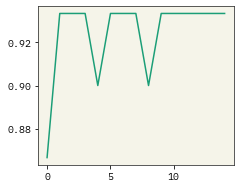

In [22]:
plt.plot(result.history['val_binary_accuracy'])
test_result = model.evaluate(test_data)
plt.show()

In [25]:
# # serialize model to JSON
# model_json = model.to_json()
# with open("../saved_models/shp2-rnn/PN_model.json", "w") as json_file:
#     json_file.write(model_json)
# # serialize weights to HDF5
# model.save_weights("../saved_models/shp2-rnn/PN_model_weights.h5")